In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
trx_d = 'Data/Trx Data.csv'
df = pd.read_csv(trx_d, parse_dates = ['Date'])
df.head()

,CardID,Date,Amount
0,C0100000199,2001-08-20,229.00
1,C0100000199,2001-06-28,139.00
2,C0100000199,2001-12-29,229.00
3,C0100000343,2001-07-27,49.00
4,C0100000343,2001-02-02,169.99


In [3]:
df.shape

(69215, 3)

In [4]:
df.isna().any()

CardID    False
Date      False
Amount    False
dtype: bool

In [5]:
df['CardID'].value_counts()

C0104879403    30
C0104719366    30
C0104667895    30
C0105838593    30
C0100891038    30
               ..
C0103170975     1
C0104921022     1
C0103192316     1
C0106183544     1
C0104524841     1
Name: CardID, Length: 12589, dtype: int64

In [6]:
df.dtypes

CardID            object
Date      datetime64[ns]
Amount           float64
dtype: object

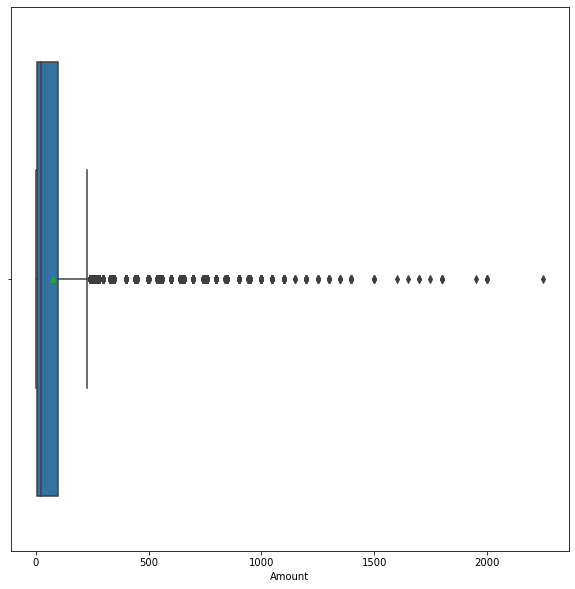

In [7]:
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.boxplot(x = df['Amount'], showmeans = True)

Data is extremely skewed positively. We will transform the data using MinMaxScaler since we only want +ve values.

In [8]:
df[['Amount']] = df[['Amount']].values.reshape(-1, 1)
transformer = preprocessing.MinMaxScaler().fit(df[['Amount']])
df[['Amount']] = transformer.transform(df[['Amount']])
df

,CardID,Date,Amount
0,C0100000199,2001-08-20,0.101228
1,C0100000199,2001-06-28,0.061183
2,C0100000199,2001-12-29,0.101228
3,C0100000343,2001-07-27,0.021139
4,C0100000343,2001-02-02,0.074972
...,...,...,...
69210,C0106596676,2001-02-07,0.083430
69211,C0106596676,2001-02-18,0.021139
69212,C0106596676,2001-02-10,0.010456
69213,C0106596676,2001-07-15,0.021579


In [9]:
maxdate = df['Date'].max() + timedelta(days = 1)

df2 = pd.DataFrame(df.groupby('CardID')['Amount'].sum())
df2['Recency'] = df2.index.map(df.groupby('CardID')['Date'].agg(lambda x: maxdate - x.min())).days
df2['Frequency'] = df2.index.map(df.groupby('CardID')['Amount'].count())
df2 = df2[['Recency', 'Frequency', 'Amount']]
df2 = df2.rename(columns = {'Amount': 'Monetary'})
df2

,Recency,Frequency,Monetary
CardID,,,
C0100000199,186,3,0.263638
C0100000343,332,6,0.307896
C0100000375,243,4,0.097005
C0100000482,278,4,0.085437
C0100000689,222,2,0.189107
...,...,...,...
C0106595162,206,2,0.171750
C0106596136,320,2,0.047168
C0106596422,332,2,0.420474


In [10]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 9999)
    kmeans.fit(df2)
    inertia.append(kmeans.inertia_)

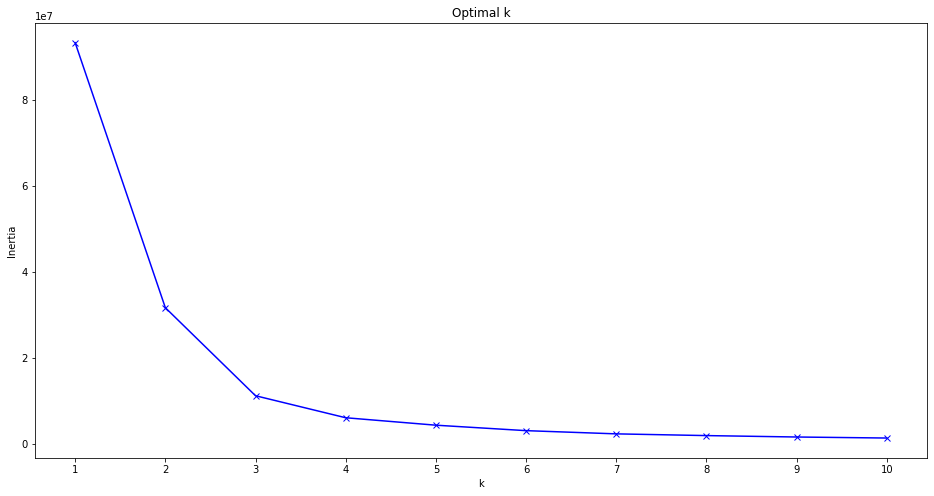

In [11]:
plt.figure(figsize = (16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(K)
plt.title('Optimal k')
plt.show()

Elbow is 3

In [12]:
kmeans = KMeans(n_clusters = 3, random_state = 9999)
clusters = kmeans.fit_predict(df2)
df2['Clusters'] = pd.Series(clusters, index = df2.index)
df2

,Recency,Frequency,Monetary,Clusters
CardID,,,,
C0100000199,186,3,0.263638,0
C0100000343,332,6,0.307896,1
C0100000375,243,4,0.097005,0
C0100000482,278,4,0.085437,1
C0100000689,222,2,0.189107,0
...,...,...,...,...
C0106595162,206,2,0.171750,0
C0106596136,320,2,0.047168,1
C0106596422,332,2,0.420474,1


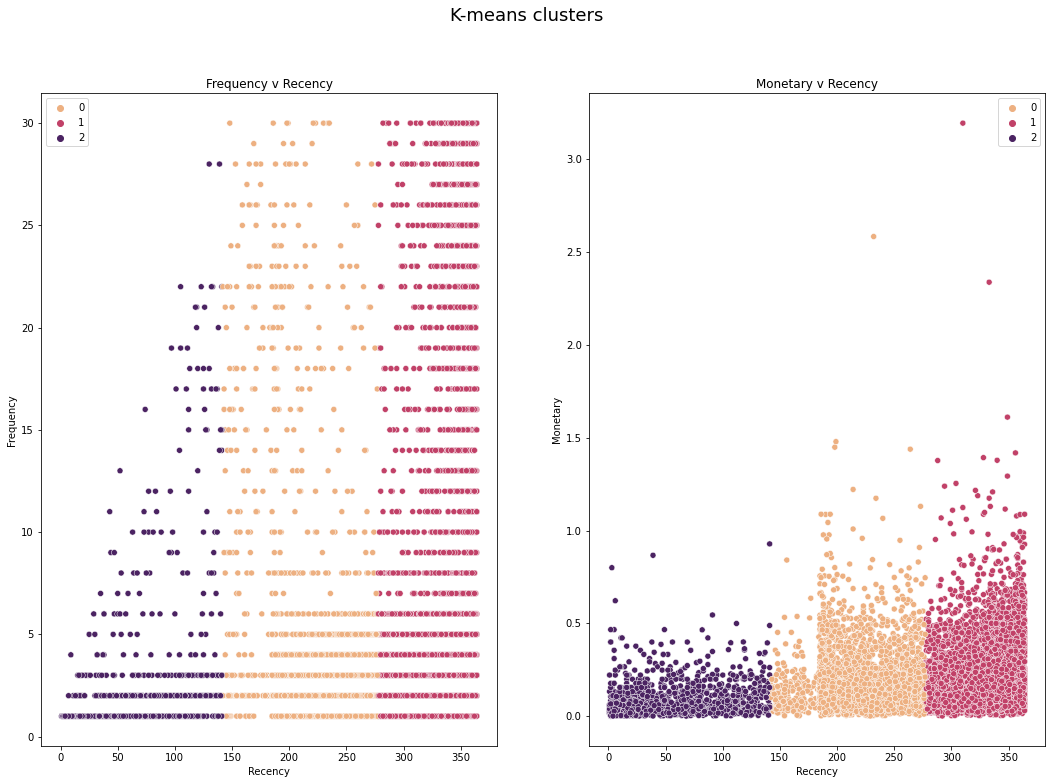

In [13]:
centroids = kmeans.cluster_centers_
u_clusters = np.unique(clusters)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12))
fig.suptitle('K-means clusters', fontsize = 18)
_ = sns.scatterplot(data = df2, x = df2.iloc[:, 0], y = df2.iloc[:, 1], 
                    palette = 'flare', hue = kmeans.labels_, legend = 'auto', ax = ax1)
_ = sns.scatterplot(data = df2, x = df2.iloc[:, 0], y = df2.iloc[:, 2], 
                    palette = 'flare', hue = kmeans.labels_, legend = 'auto', ax = ax2)
ax1.set_title('Frequency v Recency')
ax2.set_title('Monetary v Recency')
plt.show()

Text(0.5, 1.0, 'Monetary v Frequency')

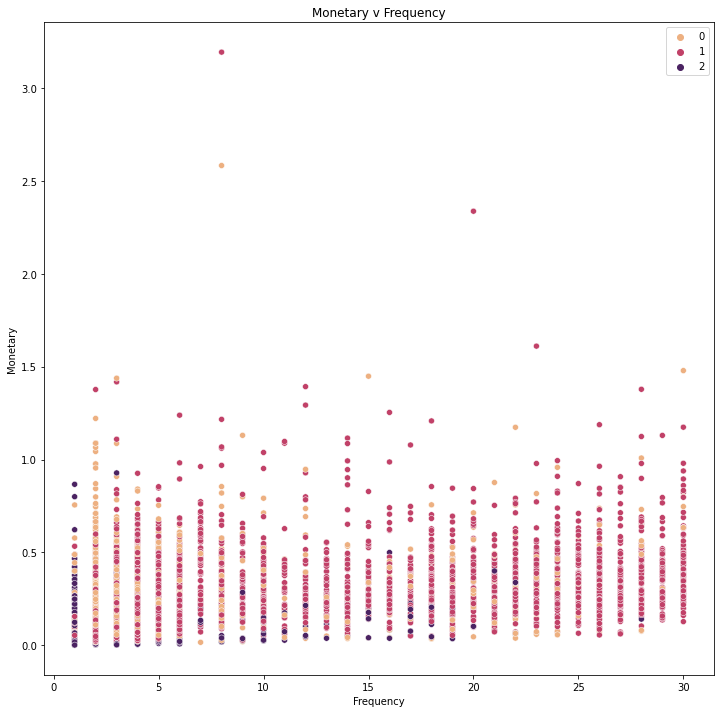

In [14]:
plt.subplots(figsize = (12, 12))
ax3 = sns.scatterplot(data = df2, x = df2.iloc[:, 1], y = df2.iloc[:, 2],
                    palette = 'flare', hue = kmeans.labels_, legend = 'auto')
ax3.set_title('Monetary v Frequency')

In [15]:
# Create labels for Recency, Frequency and MonetaryValue
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df2['Recency'], q = 4, labels = r_labels)
f_groups = pd.qcut(df2['Frequency'], q = 4, labels = f_labels)
m_groups = pd.qcut(df2['Monetary'], q = 4, labels = m_labels)
# Create new columns R and F 
df2['R-score'] = pd.Series(r_groups.values, index = df2.index)
df2['F-score'] = pd.Series(f_groups.values, index = df2.index)
df2['M-score'] = pd.Series(m_groups.values, index = df2.index)
df2['RFM Score'] = pd.Series(df2[['R-score', 'F-score', 'M-score']].sum(axis = 1), index = df2.index)
df2

,Recency,Frequency,Monetary,Clusters,R-score,F-score,M-score,RFM Score
CardID,,,,,,,,
C0100000199,186,3,0.263638,0,4,2,4,10
C0100000343,332,6,0.307896,1,2,4,4,10
C0100000375,243,4,0.097005,0,3,3,2,8
C0100000482,278,4,0.085437,1,3,3,1,7
C0100000689,222,2,0.189107,0,3,1,3,7
...,...,...,...,...,...,...,...,...
C0106595162,206,2,0.171750,0,4,1,3,8
C0106596136,320,2,0.047168,1,2,1,1,4
C0106596422,332,2,0.420474,1,2,1,4,7


In [16]:
df2.groupby(['Clusters', 'RFM Score']).size()

Clusters  RFM Score
0         5             361
          6             750
          7             938
          8             982
          9             768
          10            320
          11            228
          12            138
1         3             162
          4             531
          5             849
          6            1215
          7            1308
          8            1190
          9            1300
          10            440
          11             44
2         6             611
          7             163
          8             113
          9             113
          10             26
          11             30
          12              9
dtype: int64

In [17]:
df2['Clusters'].value_counts()

1    7039
0    4485
2    1065
Name: Clusters, dtype: int64

In [18]:
df2.groupby('Clusters')['Monetary'].sum()

Clusters
0     786.294259
1    1471.504113
2      97.405022
Name: Monetary, dtype: float64